# Capstone Project: Predicting FDA Approval of Biological Products

**Research Question**
How can we predict whether a biological product will be FDA-approved or rejected based on its applicant, product type, dosage, and other features?



### Getting Started

Expected Data Source(s): The primary data source will be the FDA Purple Book, which contains information on FDA-licensed biological products, including licensed biosimilar and interchangeable products, and their reference products. The data can be accessed via the official FDA website: FDA Purple Book Database.



In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning models and preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Time utility
import time

# For inline plotting in Jupyter notebooks
%matplotlib inline
 

**Step 1: Load the Dataset**

In [5]:
# Load the Purple Book dataset
df = pd.read_csv('data/purplebook.csv')
print("Data Loaded Successfully")

Data Loaded Successfully


**Step 2: Create Target Column (Approval Status)**

We create a new column Approval_Status based on 'Approval Date' and 'Marketing Status' to define approved vs rejected/not approved products.

In [7]:
def determine_approval_status(row):
    if pd.notnull(row['Approval Date']) and row['Marketing Status'] in ['Licensed', 'Rx']:
        return 'Approved'
    else:
        return 'Rejected or Not Approved'

df['Approval_Status'] = df.apply(determine_approval_status, axis=1)
df['Approval_Status_binary'] = df['Approval_Status'].map({'Approved': 1, 'Rejected or Not Approved': 0})


In [8]:
#Quick overview
df.head()

,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date,Approval_Status,Approval_Status_binary
0,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),1000MG,For Injection,Intravenous,Single-Dose Vial,...,1871,1,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1
1,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),500MG,For Injection,Intravenous,Single-Dose Vial,...,1871,2,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Rejected or Not Approved,0
2,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),1000MG/20ML,Injection,Intravenous,Single-Dose Vial,...,1871,3,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1
3,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),4000MG/80ML,Injection,Intravenous,Single-Dose Vial,...,1871,4,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1
4,U,Grifols Therapeutics LLC,103174,"prolastin,prolastin-c,prolastin-c liquid",Alpha-1-Proteinase Inhibitor (Human),351(a),500MG/10ML,Injection,Intravenous,Single-Dose Vial,...,1871,5,CBER,NaN,NaN,NaN,NaN,2-Dec-94,Approved,1


In [9]:
#Dataset Info
print("\n Dataset Info:")
print(df.info())


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6279 entries, 0 to 6278
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   N/R/U                                        194 non-null    object 
 1   Applicant                                    6279 non-null   object 
 2   BLA Number                                   6279 non-null   int64  
 3   Proprietary Name                             5262 non-null   object 
 4   Proper Name                                  6279 non-null   object 
 5   BLA Type                                     6279 non-null   object 
 6   Strength                                     6276 non-null   object 
 7   Dosage Form                                  6255 non-null   object 
 8   Route of Administration                      6255 non-null   object 
 9   Product Presentation                         6174 non-null

In [10]:
#Check for missing values
print("\n Missing Values:")
print(df.isnull().sum())


 Missing Values:
N/R/U                                          6085
Applicant                                         0
BLA Number                                        0
Proprietary Name                               1017
Proper Name                                       0
BLA Type                                          0
Strength                                          3
Dosage Form                                      24
Route of Administration                          24
Product Presentation                            105
Marketing Status                                  0
Licensure                                         0
Approval Date                                    45
Ref. Product Proper Name                       2872
Ref. Product Proprietary Name                  5538
Supplement Number                              2255
Submission Type                                  27
License Number                                    0
Product Number                                

In [11]:
#Check column names
print("\n Columns:")
print(df.columns.tolist())


 Columns:
['N/R/U', 'Applicant', 'BLA Number', 'Proprietary Name', 'Proper Name', 'BLA Type', 'Strength', 'Dosage Form', 'Route of Administration', 'Product Presentation', 'Marketing Status', 'Licensure', 'Approval Date', 'Ref. Product Proper Name', 'Ref. Product Proprietary Name', 'Supplement Number', 'Submission Type', 'License Number', 'Product Number', 'Center', 'Date of First Licensure', 'Exclusivity Expiration Date', 'First Interchangeable Exclusivity Exp. Date', 'Ref. Product Exclusivity Exp. Date', 'Orphan Exclusivity Exp. Date', 'Approval_Status', 'Approval_Status_binary']


In [12]:
#Check for duplicates
print("\n Checking for duplicates:")
print(f"Number of duplicate rows: {df.duplicated().sum()}")


 Checking for duplicates:
Number of duplicate rows: 4158


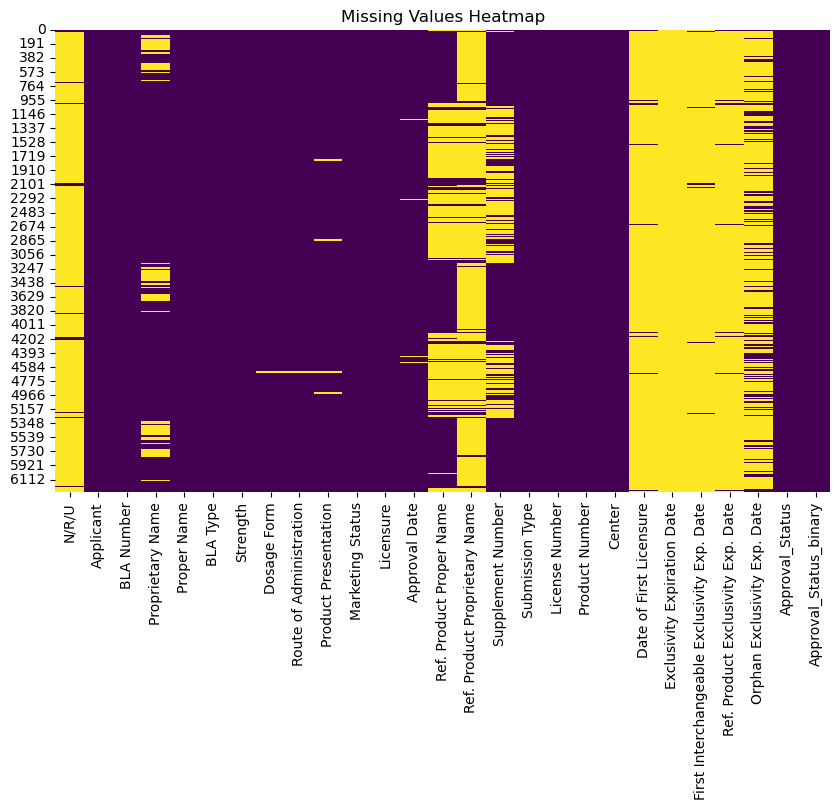

In [13]:
# Quick Data Visualizations
# Now plotting
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


In [14]:
# Descriptive Analytics 
 
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe(include='all')
 

,N/R/U,Applicant,BLA Number,Proprietary Name,Proper Name,BLA Type,Strength,Dosage Form,Route of Administration,Product Presentation,...,License Number,Product Number,Center,Date of First Licensure,Exclusivity Expiration Date,First Interchangeable Exclusivity Exp. Date,Ref. Product Exclusivity Exp. Date,Orphan Exclusivity Exp. Date,Approval_Status,Approval_Status_binary
count,194,6279,6279.00,5262,6279,6279,6276,6255,6255,6174,...,6279.00,6279.00,6279,99,0.00,106,99,1603,6279,6279.00
unique,2,258,NaN,708,611,3,818,24,31,26,...,NaN,NaN,2,30,NaN,9,30,228,2,NaN
top,U,Amgen Inc.,NaN,Aranesp,somatropin,351(a),"10,000BAU/ML",Injection,Subcutaneous,Single-Dose Vial,...,NaN,NaN,CDER,29-Aug-12,NaN,Date TBD,29-Feb-24,24-Mar-02,Approved,NaN
freq,120,329,NaN,147,162,5700,288,2264,2164,2633,...,NaN,NaN,3218,6,NaN,39,6,54,4802,NaN
mean,NaN,NaN,240463.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1511.63,3.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.76
std,NaN,NaN,270984.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,649.80,4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.42
min,NaN,NaN,17016.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
25%,NaN,NaN,103055.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1216.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
50%,NaN,NaN,125063.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1752.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
75%,NaN,NaN,125738.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2003.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00


# Initial Data Understanding

In this section, we summarize the first insights after loading and analyzing the dataset.

---

## Dataset Overview

- **Shape of the Dataset:**  
  The dataset contains **6,279 rows** and **27 columns**.

- **Variables Classification:**
  - **Numeric Columns:** 0
  - **Integer-Categorical Columns:** 3
  - **String-Categorical Columns:** 8
  - **String-Boolean Columns:** 3
  - **Numeric-Boolean Columns:** 1
  - **Discrete String Columns:** 7
  - **Date Time Columns:** 0
  - **ID Columns:** 0
  - **Low-information Columns Identified:** 5 columns removed (`N/R/U`, `Date of First Licensure`, `Exclusivity Expiration Date`, `First Interchangeable Exclusivity Exp. Date`, `Ref. Product Exclusivity Exp. Date`)

- **Duplicates:**
  - **4,158 duplicate rows** found.  
    These should be dropped during preprocessing.  
    *Note:* Dropping duplicates can sometimes change column data types.

---

## Key Takeaways from Data Quality Analysis

| Feature | Type | Key Observations |
|:--------|:-----|:-----------------|
| **Applicant** | Object | No missing values. High cardinality (258 unique values). Recommend hash encoding or text embedding. |
| **BLA Number** | Integer | No missing values. 711 outliers present. Outliers need capping. |
| **Proprietary Name** | Object | 339 missing values (16%). High cardinality (708 unique values). Mixed data types detected. |
| **Proper Name** | Object | No missing values. High cardinality (611 unique values). |
| **BLA Type** | Object | No issues detected. |
| **Strength** | Object | 1 missing value. High cardinality (818 unique values). Mixed types detected. |
| **Dosage Form** | Object | 8 missing values. Rare categories present. Mixed types detected. |
| **Route of Administration** | Object | 8 missing values. Rare categories present. Mixed types detected. |
| **Product Presentation** | Object | 35 missing values. Rare categories present. Mixed types detected. |
| **Marketing Status** | Object | No missing values. Rare categories (`OTC`, `Disc*`) need grouping. |
| **Licensure** | Object | No missing values. Rare category (`Revoked`) needs grouping. |
| **Approval Date** | Object | 15 missing values. High cardinality (908 unique values). Mixed types detected. |
| **Ref. Product Proper Name** | Object | 968 missing values (~46%). Rare categories detected. |
| **Ref. Product Proprietary Name** | Object | 1,861 missing values (~88%). Rare categories detected. |
| **Supplement Number** | Object | 761 missing values (~36%). High cardinality (182 unique values). Mixed types detected. |
| **Submission Type** | Object | 10 missing values. Mixed types detected. |
| **License Number** | Integer | No missing values. 101 outliers detected. |
| **Product Number** | Integer | No missing values. 101 outliers detected. |
| **Center** | Object | No issues detected. |
| **Orphan Exclusivity Exp. Date** | Object | 1,583 missing values (~75%). High cardinality (228 unique values). Mixed types detected. |

---

## Major Data Quality Issues Identified

- **High Missingness:**  
  Columns like `Ref. Product Proprietary Name` (~88%), `Orphan Exclusivity Exp. Date` (~75%), and `Supplement Number` (~36%) have significant missing data.

- **High Cardinality:**  
  Features such as `Applicant`, `Proprietary Name`, `Proper Name`, and `Strength` have hundreds of unique values, which could cause dimensionality issues.

- **Outliers:**  
  - `BLA Number`: 711 outliers detected.
  - `Product Number`: 101 outliers detected.
  - `License Number`: 101 outliers detected.

- **Rare Categories:**  
  Features such as `Marketing Status`, `Licensure`, `Dosage Form`, `Route of Administration`, and `Product Presentation` have rare categories needing grouping.

- **Mixed Data Types:**  
  Several features show mixed data types (`object` and `float`), requiring cleanup.

- **Duplicates:**  
  4,158 duplicate rows found; should be dropped.

- **Low Information Columns:**  
  5 columns identified with very low variance and removed.

---

## Next Steps

1. **Drop duplicate rows** carefully, ensuring data types remain consistent.
2. **Handle missing values:**
   - Impute missing categorical variables with mode or a constant.
   - Consider dropping columns with extreme missingness.
3. **Manage high cardinality:**
   - Use encoding techniques (e.g., hash encoding, embeddings).
4. **Cap or remove outliers** in `BLA Number`, `License Number`, and `Product Number`.
5. **Group rare categories** into "Other" to reduce noise.
6. **Clean mixed data types** in columns showing multiple types.
7. **Feature engineering:**  
   Consider creating new features based on Approval Date (e.g., year, month) if needed.

---


# Data Cleaning

**Step 3: Drop Unnecessary Columns**

We drop columns that provide minimal value for prediction or serve as unique identifiers

In [18]:
 columns_to_drop = ['N/R/U', 'Date of First Licensure', 'Exclusivity Expiration Date', 
                   'First Interchangeable Exclusivity Exp. Date', 'Ref. Product Exclusivity Exp. Date', 'Approval Date']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


**Step 4: Handle Missing Values and Data Cleaning**

Convert 'Strength' to numeric.

Impute missing values.

Drop duplicates.

We drop columns that provide minimal value for prediction or serve as unique identifiers

In [20]:
# Strength column cleaning
df['Strength'] = df['Strength'].astype(str)
df['Strength'] = df['Strength'].str.extract(r'(\d+)', expand=False)
df['Strength'] = pd.to_numeric(df['Strength'], errors='coerce')
df['Strength'] = df['Strength'].fillna(df['Strength'].median())

# Fill missing categorical values
df['Proprietary Name'] = df['Proprietary Name'].fillna(df['Proprietary Name'].mode()[0])
df['Product Presentation'] = df['Product Presentation'].fillna('Not Available')

# Drop duplicate rows
df = df.drop_duplicates()


**Step 5: Outlier Capping using IQR Method**

Outliers are capped to prevent model distortion.

In [22]:
def cap_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column.clip(lower=lower_bound, upper=upper_bound)

df['BLA Number'] = cap_outliers_iqr(df['BLA Number'])
df['Strength'] = cap_outliers_iqr(df['Strength'])
df['License Number'] = cap_outliers_iqr(df['License Number'])
df['Product Number'] = cap_outliers_iqr(df['Product Number'])


**Step 6: Handle Rare Categories**

Rare categories are grouped into 'Other' to reduce noise.

In [24]:
def group_rare_categories(column, threshold=10):
    value_counts = column.value_counts()
    rare_values = value_counts[value_counts < threshold].index
    return column.replace(rare_values, 'Other')

categorical_columns_for_rare = [
    'Proprietary Name', 'Proper Name', 'Supplement Number', 
    'Ref. Product Proper Name', 'Licensure', 'Product Presentation', 
    'Ref. Product Proprietary Name'
]
for col in categorical_columns_for_rare:
    df[col] = group_rare_categories(df[col])


 **Step 7: Additional Cleaning for Categorical Columns**

In [26]:
df['Route of Administration'] = df['Route of Administration'].astype(str)
df['Ref. Product Proper Name'] = df['Ref. Product Proper Name'].astype(str)

# Fill missing categorical columns
df['Dosage Form'] = df['Dosage Form'].fillna(df['Dosage Form'].mode()[0])
df['Route of Administration'] = df['Route of Administration'].fillna(df['Route of Administration'].mode()[0])
df['Ref. Product Proper Name'] = df['Ref. Product Proper Name'].fillna(df['Ref. Product Proper Name'].mode()[0])
df['Supplement Number'] = df['Supplement Number'].fillna(df['Supplement Number'].mode()[0])
df['Submission Type'] = df['Submission Type'].fillna(df['Submission Type'].mode()[0])
df['Orphan Exclusivity Exp. Date'] = df['Orphan Exclusivity Exp. Date'].fillna(df['Orphan Exclusivity Exp. Date'].mode()[0])


**Step 8: Drop Unnecessary Columns**

In [28]:
df = df.drop(columns=['Ref. Product Proprietary Name'])


**Step 9: Further Handling of High Cardinality Columns**

In [30]:
df['Applicant'] = group_rare_categories(df['Applicant'], threshold=5)
df['Orphan Exclusivity Exp. Date'] = group_rare_categories(df['Orphan Exclusivity Exp. Date'], threshold=5)
df['Marketing Status'] = df['Marketing Status'].replace({'OTC': 'Other', 'Disc*': 'Other'})


**Step 10: Log Transformation for Skewed Columns**


In [32]:
df['License Number'] = np.log1p(df['License Number'])


**Step 11: Final Cleaning Steps**

In [34]:
df = df.convert_dtypes()

# Save the cleaned dataset
df.to_csv('data/purplebook_cleaned_final.csv', index=False)

print(" Data Cleaned Successfully")
print(df.head())


 Data Cleaned Successfully
                  Applicant  BLA Number Proprietary Name  \
0  Grifols Therapeutics LLC   103174.00            Other   
1  Grifols Therapeutics LLC   103174.00            Other   
2  Grifols Therapeutics LLC   103174.00            Other   
3  Grifols Therapeutics LLC   103174.00            Other   
4  Grifols Therapeutics LLC   103174.00            Other   

                            Proper Name BLA Type  Strength    Dosage Form  \
0  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485  For Injection   
1  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485  For Injection   
2  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485      Injection   
3  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485      Injection   
4  Alpha-1-Proteinase Inhibitor (Human)   351(a)       485      Injection   

  Route of Administration Product Presentation Marketing Status Licensure  \
0             Intravenous     Single-Dose Vial               Rx  License

# Feature Engineering 

**Step 12: Feature Creation**

Adding new features based on domain understanding.

In [37]:
# Text features
df['Proprietary_Name_Length'] = df['Proprietary Name'].apply(lambda x: len(str(x)))
df['Proper_Name_Length'] = df['Proper Name'].apply(lambda x: len(str(x)))

# Top Applicants
top_applicants = df['Applicant'].value_counts().nlargest(10).index
df['Top_Applicant_Flag'] = df['Applicant'].apply(lambda x: 1 if x in top_applicants else 0)

# Simplified Route of Administration
def simplify_route(route):
    route = route.lower()
    if 'injection' in route:
        return 'Injection'
    elif 'oral' in route:
        return 'Oral'
    elif 'topical' in route:
        return 'Topical'
    else:
        return 'Other'

df['Route_Simple'] = df['Route of Administration'].apply(simplify_route)


# Data Cleaning - Final check 

The code generates several visualizations to explore the dataset: histograms with KDE for continuous features, count plots for categorical features, a heatmap to visualize missing values, and a correlation heatmap for numerical variables. These plots help to understand the data distribution, detect missing values, and examine relationships between continuous variables, providing valuable insights for further analysis or modeling.

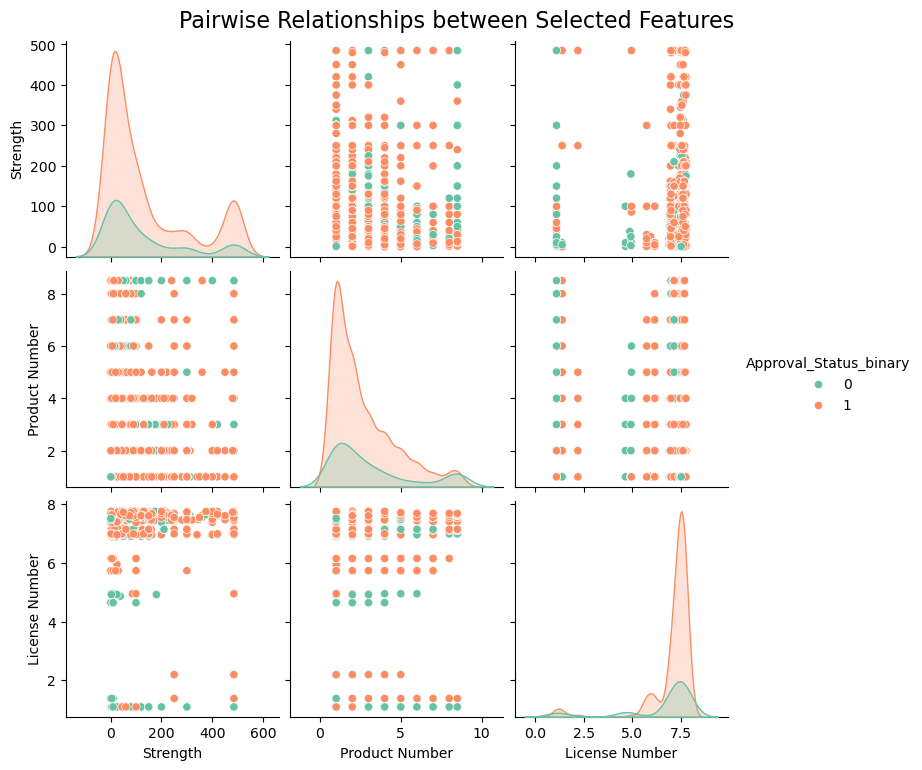

In [39]:
 
import seaborn as sns
import matplotlib.pyplot as plt

# Select a few important columns for visualization
selected_features = ['Strength', 'Approval_Status_binary', 'Product Number', 'License Number']   

# Create a pairplot
sns.pairplot(df[selected_features], hue='Approval_Status_binary', diag_kind='kde', palette='Set2')
plt.suptitle('Pairwise Relationships between Selected Features', y=1.02, fontsize=16)
plt.show()


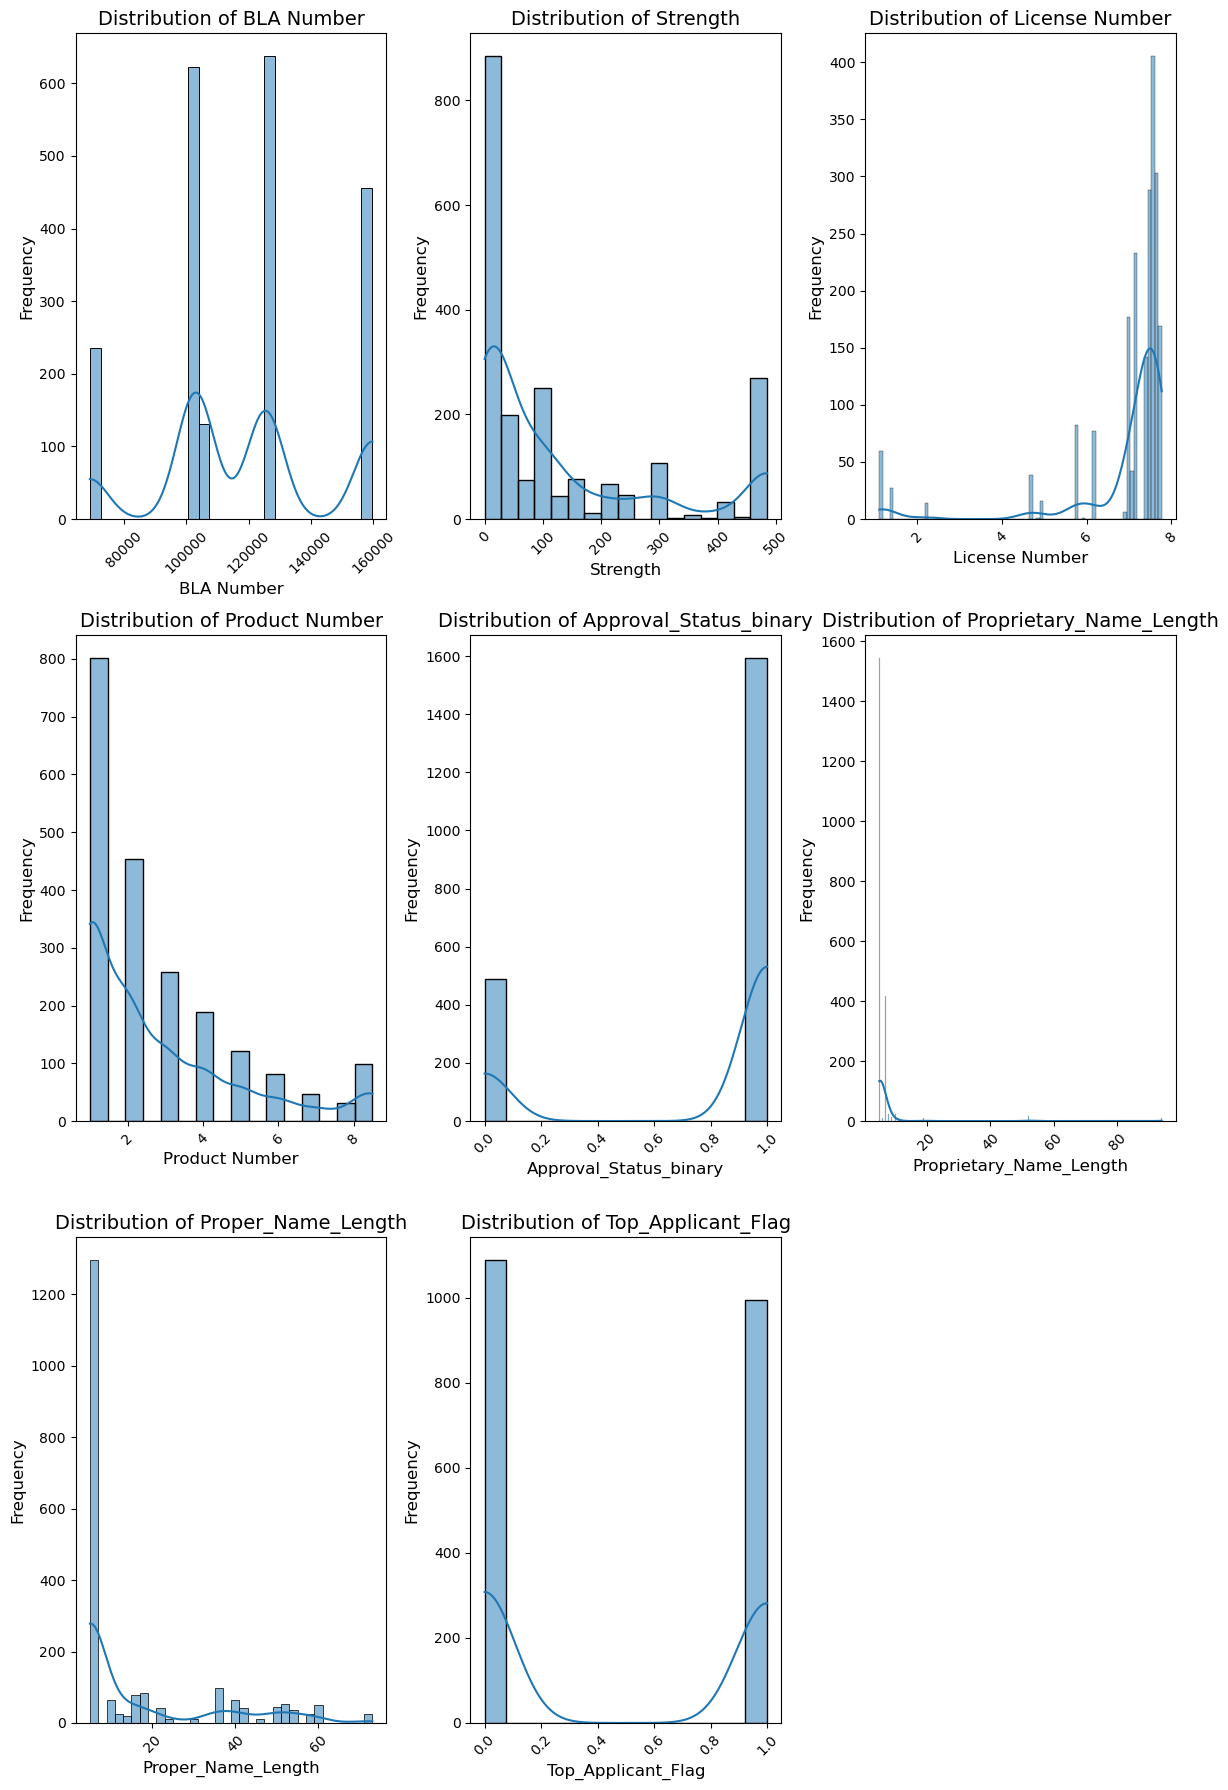

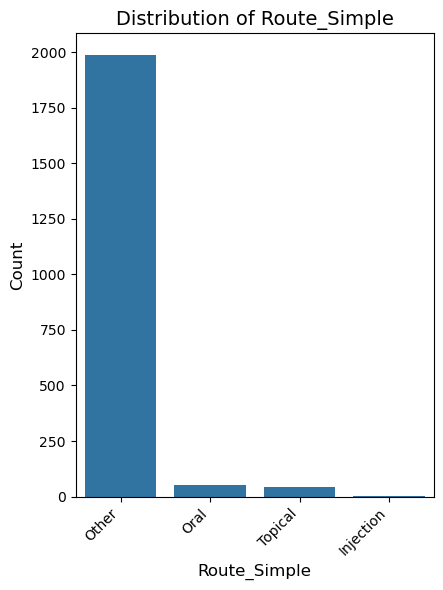

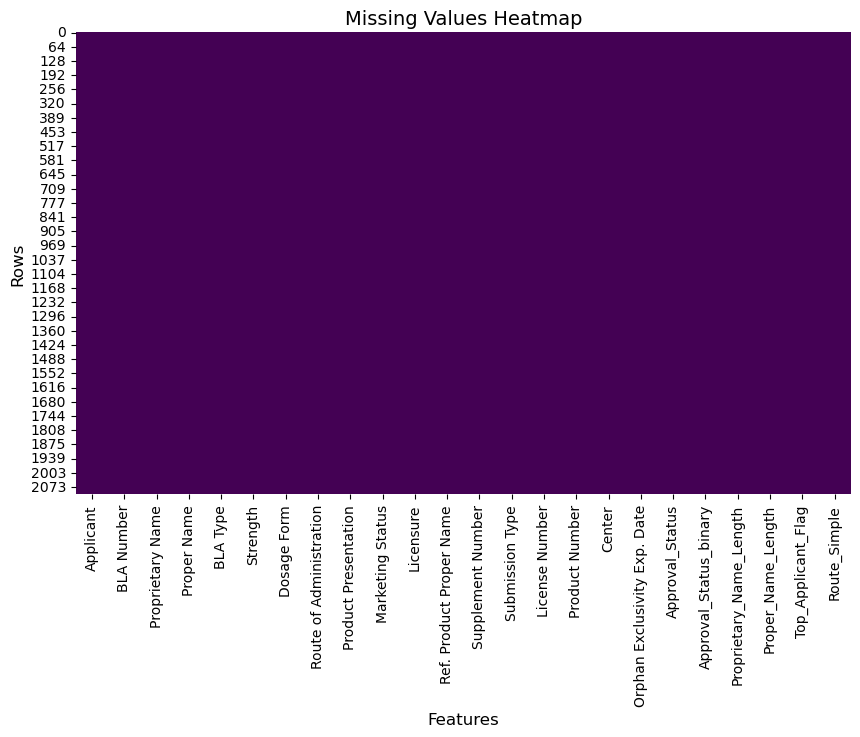

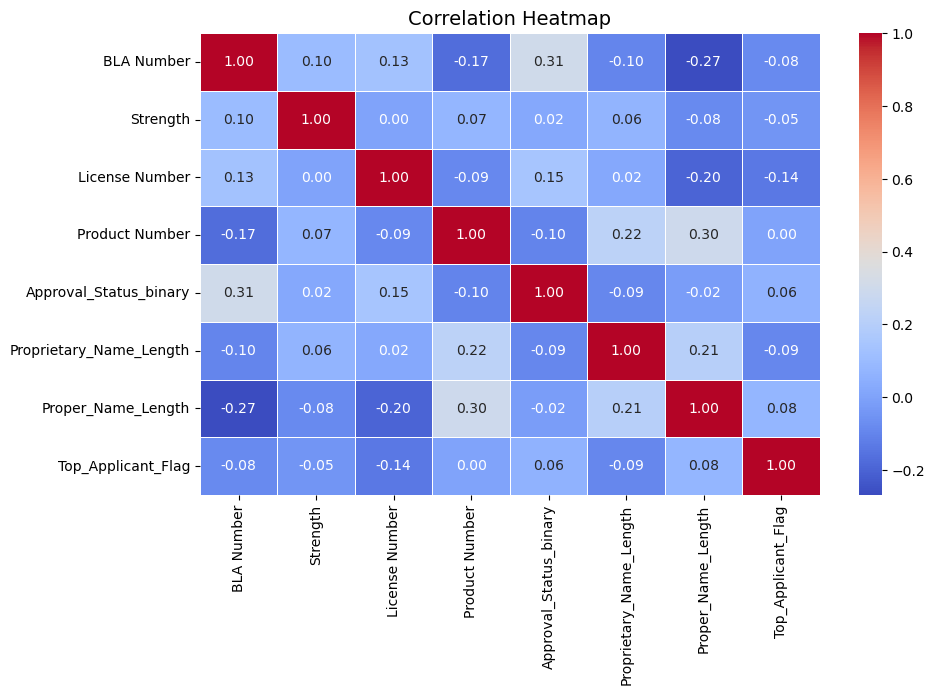

In [40]:
# 1. Visualization for Continuous Features
# Select numerical columns for continuous variables
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the plot for continuous variables (Histograms)
n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(numerical_columns) // n_cols) + (1 if len(numerical_columns) % n_cols != 0 else 0)  # Number of rows needed

plt.figure(figsize=(12, 6 * n_rows))  # Adjust figure size based on the number of rows
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Create subplots for each continuous column
    sns.histplot(df[col], kde=True)  # Histogram + KDE for distribution
    plt.title(f'Distribution of {col}', fontsize=14)  # Descriptive title
    plt.xlabel(col, fontsize=12)  # Label for x-axis
    plt.ylabel('Frequency', fontsize=12)  # Label for y-axis
    plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
    
plt.tight_layout()
plt.show()

# 2. Visualization for Categorical Features
categorical_columns = df.select_dtypes(include=['object']).columns

# Set up the plot for categorical variables (Countplots)
n_cols = 3  # Adjust to fit your number of subplots
n_rows = (len(categorical_columns) // n_cols) + (1 if len(categorical_columns) % n_cols != 0 else 0)

plt.figure(figsize=(12, 6 * n_rows))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(n_rows, n_cols, i)  # Create subplots for each categorical column
    sns.countplot(x=df[col], order=df[col].value_counts().index)  # Countplot for categorical data
    plt.title(f'Distribution of {col}', fontsize=14)  # Descriptive title
    plt.xlabel(col, fontsize=12)  # Label for x-axis
    plt.ylabel('Count', fontsize=12)  # Label for y-axis
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    
plt.tight_layout()
plt.show()

# 3. Missing Values Heatmap (if applicable)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')  # Visualize missing data
plt.title('Missing Values Heatmap', fontsize=14)  # Descriptive title
plt.xlabel('Features', fontsize=12)  # Label for x-axis
plt.ylabel('Rows', fontsize=12)  # Label for y-axis
plt.show()

# 4. Correlation Heatmap (for numerical variables)
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns  # Get only numeric columns
correlation_matrix = df[numerical_columns].corr()  # Compute correlation matrix for numeric columns

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)  # Correlation matrix
plt.title('Correlation Heatmap', fontsize=14)  # Descriptive title
plt.show()


# Baseline Model Development

**Step 13: Train-Test Split**

In [43]:

X = df.drop(columns=['Approval_Status_binary'])
y = df['Approval_Status_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Feature Engineering 

Feature Engineering 

In [46]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Approval_Status_binary'])
y = df['Approval_Status_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [49]:
y.value_counts()


Approval_Status_binary
1    1592
0     490
Name: count, dtype: Int64

**Step -14 Create the Baseline Model**

For the baseline, you'll predict the most frequent class (i.e., the class with the highest occurrence) for all samples. This can be done easily using a majority class classifier.

In [51]:

# Instantiate the DummyClassifier with strategy="most_frequent" (predict the majority class)
baseline_model = DummyClassifier(strategy="most_frequent")

# Fit the model
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate the performance of the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")


Baseline Accuracy: 0.7722


**Step 14: Preprocessing and Pipeline for Logistic Regression**

Use Logistic Regression to build a basic model on your data.  

In [53]:

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Define a preprocessor with OneHotEncoding for categorical columns and scaling for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['number']).columns),  # Apply scaling to numeric columns
        ('cat', OneHotEncoder(), categorical_columns)  # Apply OneHotEncoding to categorical columns
    ]
)

# Create a pipeline that first preprocesses and then applies Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the pipeline with training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7890
Confusion Matrix:
[[ 27  68]
 [ 20 302]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.28      0.38        95
         1.0       0.82      0.94      0.87       322

    accuracy                           0.79       417
   macro avg       0.70      0.61      0.63       417
weighted avg       0.76      0.79      0.76       417

